In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, Adamax, Ftrl
from keras.callbacks import EarlyStopping


2024-06-12 15:03:31.748274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 15:03:31.748382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 15:03:31.871352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_excel('/content/drive/My Drive/PTDLKD_IS403/processed_data/processed_data.xlsx')
df = pd.read_excel('/kaggle/input/eth-data/processed_data.xlsx')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
ftrl_optimizer = Ftrl(learning_rate=0.01, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [9]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=ftrl_optimizer)
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1, callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.1653 - val_loss: 0.0615
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1332 - val_loss: 0.0480
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1280 - val_loss: 0.0395
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1152 - val_loss: 0.0334
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1134 - val_loss: 0.0286
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1129 - val_loss: 0.0248
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1002 - val_loss: 0.0217
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1063 - val_loss: 0.0193
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1023 - val_loss: 0.0172
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0990 - val_loss: 0.0154
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0974 - val_loss: 0.0139
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [14]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 1430.4079585795787
Testing RMSE: 1430.6119754336294
Validation MSE: 2046066.9279677977
Testing MSE: 2046650.6242541112
Validation MAE: 1430.4079501998435
Testing MAE: 1430.6119744850444
Validation MAPE: 308690.3940781312%
Testing MAPE: 484384.54933282745%


<h2> 30 days

In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Ensure only the last 100 elements are used
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        # Remove the first element to maintain the size of 100
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# print(lst_output)

0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

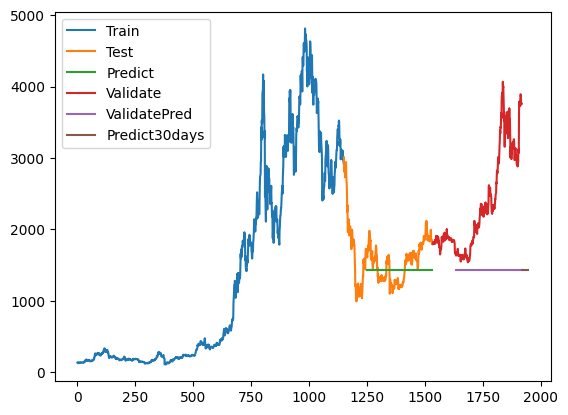

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

<h2> 60 days

In [17]:
# 14. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

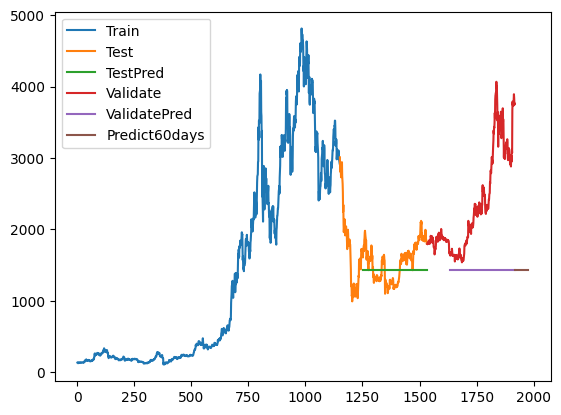

In [18]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Validate','ValidatePred','Predict60days'])
plt.show()

<h2> 90 days

In [19]:
# 16. Dự báo 90 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

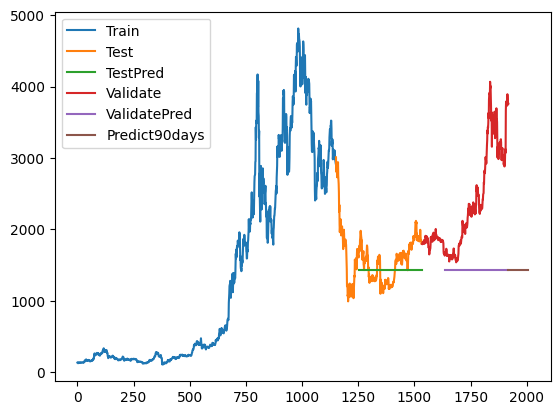

In [20]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Validate','ValidatePred','Predict90days'])
plt.show()